# 1 | Klasifikasi Natural Language Processing pada Data Twitter

## Dalam Notebook ini akan menjelaskan beberapa hal: 

1. Klasifikasi Text (Natural Language Processing) dengan algoritma Machine Learning

2. Dataset yang digunakan https://github.com/meisaputri21/Indonesian-Twitter-Emotion-Dataset/blob/master/Twitter_Emotion_Dataset.csv, yang berisi data postingan pada twitter dengan 5 label

3. Cleaning & Preprocessing Data:
.
- Menghilangkan record yang memiliki nilai kosong / terduplikat
- Menghilangkan karakter-karakter kata yang dianggap tidak penting dan menghilangkan karakter spesial (Punctuation)
- Mengubah semua kata menjadi lowercase
- Mengubah kata-kata yang singkat dengan replacing data dari dictionary https://github.com/riochr17/Analisis-Sentimen-ID/blob/master/kamus/kbba.txt
- Menghilangkan kata-kata yg tidak penting (stopword)
- Mengembalikan kata-kata kedalam bentuk asli nya nya (Stemming dengan Sastrawi)
- Menghapus kata yang memiliki kurang dari 3 karakter
.

#### 1. Import Library dan Dependencies

In [1]:
import nltk
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import re
import itertools
import string
import gensim
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
nltk.download('punkt')

<h2 id="understanding_data">Understanding the Data</h2>

### `Twitter_Emotion_Dataset.csv`:
Saya sudah download dataset, **`Twitter_Emotion_Dataset.csv`**, dimana berisi data postingan di Twitter kemudian 5 label yang berbeda. [Dataset source](https://github.com/meisaputri21/Indonesian-Twitter-Emotion-Dataset/blob/master/Twitter_Emotion_Dataset.csv)

- **label** e.g. Anger
- **tweet** e.g. soal jalan jatibaru polisi gertak gubernur ema...


In [4]:
df_tweets = pd.read_csv("../NLP-Project/Twitter_Emotion_Dataset.csv")
df_tweets.isna().sum()

label    0
tweet    0
dtype: int64

#### 2. Menghapus data yang terduplikat

In [5]:
df_tweets = df_tweets.drop_duplicates()
df_tweets.duplicated().sum()

0

#### 3. Membuat fungsi untuk melakukan preprocessing dataset

In [7]:
factory = StopWordRemoverFactory()
sw = factory.get_stop_words()

def remove_tweet_special(text):
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"").replace('USERNAME', "").replace('-', " ").replace(',', " ")
    text = text.encode('ascii', 'replace').decode('ascii')
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    return text.replace("http://", " ").replace("https://", " ")
                
def remove_number(text):
    return  re.sub(r"\d+", "", text)

def remove_punctuation(text):
    import string
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    return " ".join(text)

def remove_whitespace_LT(text):
    return text.strip()

def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

def word_tokenize_wrapper(text):
    return word_tokenize(text)


def normalizing_words(review):
    return ''.join(''.join(s)[:1] for _, s in itertools.groupby(review))

def preprocess_tweet(tweet):
    tweet.lower()
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    output = stemmer.stem(tweet)
    
    return output

#### 4. Loading Data Dictionary untuk mengubah kata-kata singkat

In [8]:
d = {}
with open("../NLP-Project/kbba.txt") as f:
    for line in f:
        (key, val) = line.split('\t')
        d[key] = val
        d[key] = re.sub(r'\n', '', d[key])

def process(ss):
    for line in ss:
        da = ''.join(d.get(word, word) for word in re.split( '(\W+)', line))
        return da

#### 5. Code dibawah adalah proses replacing kata-kata singkat pada dataset menggunakan data dictionary yang sudah di load sebelumnya

In [9]:
df_tweets['tweet'] = df_tweets['tweet'].str.replace('[...…]','').str.split().apply(lambda x: ' '.join([d.get(e, e) for e in x]))

#### 6. Melakukan text preprocessing dengan memanggil fungsi yang sudah dibuat sebelumnya

In [10]:
df_tweets['tweet'] = df_tweets['tweet'].apply(remove_tweet_special)
df_tweets['tweet'] = df_tweets['tweet'].apply(remove_number)
df_tweets['tweet'] = df_tweets['tweet'].apply(remove_punctuation)
df_tweets['tweet'] = df_tweets['tweet'].apply(stopwords)
df_tweets['tweet'] = df_tweets['tweet'].apply(remove_whitespace_LT)
df_tweets['tweet'] = df_tweets['tweet'].apply(remove_whitespace_multiple)

In [11]:
df_tweets.head()

,label,tweet
0,anger,soal jalan jatibaru polisi gertak gubernur ema...
1,anger,sesama cewek lho kayaknya harusnya lebih rasai...
2,happy,kepingin gudeg mbarek bu hj amad foto google s...
3,anger,jln jatibaru bagian wilayah tn abangpengaturan...
4,happy,sharing pengalaman aja kemarin jam batalin tik...


#### 7. Stemming Data Menggunakan Sastrawi
Untuk menghemat waktu dalam proses stemming data menggunakan sastrawi, maka saya export kedalam format csv untuk digunakan dikemudian hari tanpa harus melakukan stemming kembali

In [12]:
# df_tweets['tweet_norm'] = df_tweets['tweet'].apply(preprocess_tweet)
# df_tweets.to_csv('tweets_preprocessed.csv')

#### 8. Load Dataset yang sudah di preposs

In [16]:
df_tweets = pd.read_csv('../NLP-Project/tweets_preprocessed.csv')
df_tweets.drop(columns={'Unnamed: 0'}, axis=1, inplace=True)
df_tweets.head()

,label,tweet,tweet_norm
0,anger,soal jalan jatibaru polisi gertak gubernur ema...,soal jalan jatibaru polisi gertak gubernur ema...
1,anger,sesama cewek lho kayaknya harusnya lebih rasai...,sama cewek lho kayak harus lebih rasain lah si...
2,happy,mau gudeg mbarek bu hj amad foto google sengaj...,mau gudeg mbarek bu hj amad foto google sengaj...
3,anger,jalan jatibaru bagian wilayah tn abangpengatur...,jalan jatibaru bagi wilayah tn abangpengaturan...
4,happy,sharing pengalaman kemarin jam batalin tiket s...,sharing alam kemarin jam batalin tiket stasiun...


#### 9. Lakukan proses replacing kata-kata singkat dari data dictionary kembali untuk memastikan  tidak ada kata yang tersingkat

In [17]:
df_tweets['tweet_norm'] = df_tweets['tweet_norm'].str.replace('[...…]','').str.split().apply(lambda x: ' '.join([d.get(e, e) for e in x]))

#### 10. Lakukan proses replacing kata-kata singkat juga dari kata yang tidak di stemming dengan sastrawi

In [18]:
df_tweets['tweet_norm_unstem'] = df_tweets['tweet'].str.replace('[...…]','').str.split().apply(lambda x: ' '.join([d.get(e, e) for e in x]))

#### 11. Buat fungsi freqDist_wrapper untuk menghitung frekuensi dari setiap kata

In [19]:
def freqDist_wrapper(text):
    return FreqDist(text)

df_tweets['tweet_tokens'] = df_tweets['tweet_norm'].apply(word_tokenize_wrapper)

df_tweets['tweet_tokens_fdist'] = df_tweets['tweet_tokens'].apply(freqDist_wrapper)

print('Frequency Tokens : \n') 
print(df_tweets['tweet_tokens_fdist'].head().apply(lambda x : x.most_common()))

Frequency Tokens : 

0    [(soal, 3), (polisi, 2), (gubernur, 2), (jalan...
1    [(rasain, 2), (sama, 1), (cewek, 1), (lho, 1),...
2    [(teman, 2), (mau, 1), (gudeg, 1), (mbarek, 1)...
3    [(wilayah, 2), (otak, 2), (jalan, 1), (jatibar...
4    [(jam, 3), (sharing, 1), (alam, 1), (kemarin, ...
Name: tweet_tokens_fdist, dtype: object


In [24]:
df_tweets.shape

(4390, 6)

In [25]:
df_tweets.head()

,label,tweet,tweet_norm,tweet_norm_unstem,tweet_tokens,tweet_tokens_fdist
0,anger,soal jalan jatibaru polisi gertak gubernur ema...,soal jalan jatibaru polisi gertak gubernur ema...,soal jalan jatibaru polisi gertak gubernur ema...,"[soal, jalan, jatibaru, polisi, gertak, gubern...","{'soal': 3, 'jalan': 1, 'jatibaru': 1, 'polisi..."
1,anger,sesama cewek lho kayaknya harusnya lebih rasai...,sama cewek lho kayak harus lebih rasain lah si...,sesama cewek lho kayaknya harusnya lebih rasai...,"[sama, cewek, lho, kayak, harus, lebih, rasain...","{'sama': 1, 'cewek': 1, 'lho': 1, 'kayak': 1, ..."
2,happy,mau gudeg mbarek bu hj amad foto google sengaj...,mau gudeg mbarek bu hj amad foto google sengaj...,mau gudeg mbarek bu hj amad foto google sengaj...,"[mau, gudeg, mbarek, bu, hj, amad, foto, googl...","{'mau': 1, 'gudeg': 1, 'mbarek': 1, 'bu': 1, '..."
3,anger,jalan jatibaru bagian wilayah tn abangpengatur...,jalan jatibaru bagi wilayah tn abangpengaturan...,jalan jatibaru bagian wilayah tn abangpengatur...,"[jalan, jatibaru, bagi, wilayah, tn, abangpeng...","{'jalan': 1, 'jatibaru': 1, 'bagi': 1, 'wilaya..."
4,happy,sharing pengalaman kemarin jam batalin tiket s...,sharing alam kemarin jam batalin tiket stasiun...,sharing pengalaman kemarin jam batalin tiket s...,"[sharing, alam, kemarin, jam, batalin, tiket, ...","{'sharing': 1, 'alam': 1, 'kemarin': 1, 'jam':..."


In [26]:
# df_tweets['tweets_norm'] = df_tweets['tweet'].apply(preprocess_tweet)

#### 12. Membuat fungsi Clean_length dan convert_to_string
Bertujuan untuk menghapus kata yang memiliki kurang dari 3 karakter

In [27]:
def Clean_length(token):
    return [i for i in token if len(i) > 2]
def convert_to_string(listReview):
    return ' '.join(listReview)

df_tweets['tweet_norm2'] = df_tweets['tweet_norm'].apply(word_tokenize_wrapper)
df_tweets['tweet_norm2'] = df_tweets['tweet_norm2'].apply(Clean_length)
df_tweets['tweet_norm2'] = df_tweets['tweet_norm2'].apply(convert_to_string)
df_tweets['tweet_norm_unstem'] = df_tweets['tweet'].apply(word_tokenize_wrapper)
df_tweets['tweet_norm_unstem'] = df_tweets['tweet_norm_unstem'].apply(Clean_length)
df_tweets['tweet_norm_unstem'] = df_tweets['tweet_norm_unstem'].apply(convert_to_string)
df_tweets['tweet_norm_unstem'] = df_tweets['tweet_norm_unstem'].apply(stopwords)

<h2 id="understanding_data">Memahami dataset yang sudah di preprocess</h2>

### `Tweets_Preprocessed.csv`:
Dalam setiap kolom pada data, **`Tweets_Preprocessed.csv`**, memiliki versi kata yang berbeda-beda.

- **label** e.g. anger
- **tweet** e.g. soal jalan jatibaru polisi gertak gubernur ema...
- **tweet_norm** kata yang sudah di normalisasi/preprocess
- **tweet_norm_unstem** kata yang sudah di normalisasi/preprocess namun tanpa di stemming menggunakan Sastrawi
- **tweet_tokens** memisahkan setiap kata kemudian diubah menjadi list sebagai processing text nanti
- **tweet_tokens_fdist** Mencari frekuensi dari setiap kata
- **tweet_norm2** Kata-kata yang sudah tidak memiliki kata kurang dari 3 karakter

In [28]:
df_tweets.head()

,label,tweet,tweet_norm,tweet_norm_unstem,tweet_tokens,tweet_tokens_fdist,tweet_norm2
0,anger,soal jalan jatibaru polisi gertak gubernur ema...,soal jalan jatibaru polisi gertak gubernur ema...,soal jalan jatibaru polisi gertak gubernur ema...,"[soal, jalan, jatibaru, polisi, gertak, gubern...","{'soal': 3, 'jalan': 1, 'jatibaru': 1, 'polisi...",soal jalan jatibaru polisi gertak gubernur ema...
1,anger,sesama cewek lho kayaknya harusnya lebih rasai...,sama cewek lho kayak harus lebih rasain lah si...,sesama cewek lho kayaknya harusnya lebih rasai...,"[sama, cewek, lho, kayak, harus, lebih, rasain...","{'sama': 1, 'cewek': 1, 'lho': 1, 'kayak': 1, ...",sama cewek lho kayak harus lebih rasain lah si...
2,happy,mau gudeg mbarek bu hj amad foto google sengaj...,mau gudeg mbarek bu hj amad foto google sengaj...,mau gudeg mbarek amad foto google sengaja biar...,"[mau, gudeg, mbarek, bu, hj, amad, foto, googl...","{'mau': 1, 'gudeg': 1, 'mbarek': 1, 'bu': 1, '...",mau gudeg mbarek amad foto google sengaja biar...
3,anger,jalan jatibaru bagian wilayah tn abangpengatur...,jalan jatibaru bagi wilayah tn abangpengaturan...,jalan jatibaru bagian wilayah abangpengaturan ...,"[jalan, jatibaru, bagi, wilayah, tn, abangpeng...","{'jalan': 1, 'jatibaru': 1, 'bagi': 1, 'wilaya...",jalan jatibaru bagi wilayah abangpengaturan wi...
4,happy,sharing pengalaman kemarin jam batalin tiket s...,sharing alam kemarin jam batalin tiket stasiun...,sharing pengalaman kemarin jam batalin tiket s...,"[sharing, alam, kemarin, jam, batalin, tiket, ...","{'sharing': 1, 'alam': 1, 'kemarin': 1, 'jam':...",sharing alam kemarin jam batalin tiket stasiun...


#### 13. Import library Sklearn dan worcloud
Melakukan import library sklearn untuk fitting machine learning model, text representation, dan evaluasi model.

In [105]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from wordcloud import WordCloud

#### 14. Menghitung jumlah kata unik pada dataset

In [30]:
unique_string = set()
for x in df_tweets['tweet_norm2']:
    for y in x.split():
        unique_string.add(y)
        
len(unique_string)

12974

#### 15. Mengubah label pada dataset menjadi angka

In [31]:
df_tweets['label_id'] = df_tweets['label'].factorize()[0]
from io import StringIO
kategori_id_data = df_tweets[['label', 'label_id']].drop_duplicates().sort_values('label_id')
kategori_to_id = dict(kategori_id_data.values)
id_to_kategori = dict(kategori_id_data[['label_id', 'label']].values)

#### 16. Membuat variabel y_new sebagai label berbentuk array

In [113]:
y_list = list(df_tweets['label_id'])
y_new = np.array(y_list)

#### 17. Melakukan splitting data untuk digunakan sebagai training dan testing dengan ukuran test 0.01% atau sekitar 44 record

In [114]:
X_train, X_test, y_train, y_test = train_test_split(df_tweets['tweet_norm2'], y_new, test_size=0.01, random_state=0)

### Visualisasi kata yang sering muncul dengan wordcloud

In [116]:
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
matrix = vectorizer.fit_transform([x for x in np.array(df_tweets['tweet_tokens'])])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print ('vocab size :', len(tfidf))

vocab size : 1183


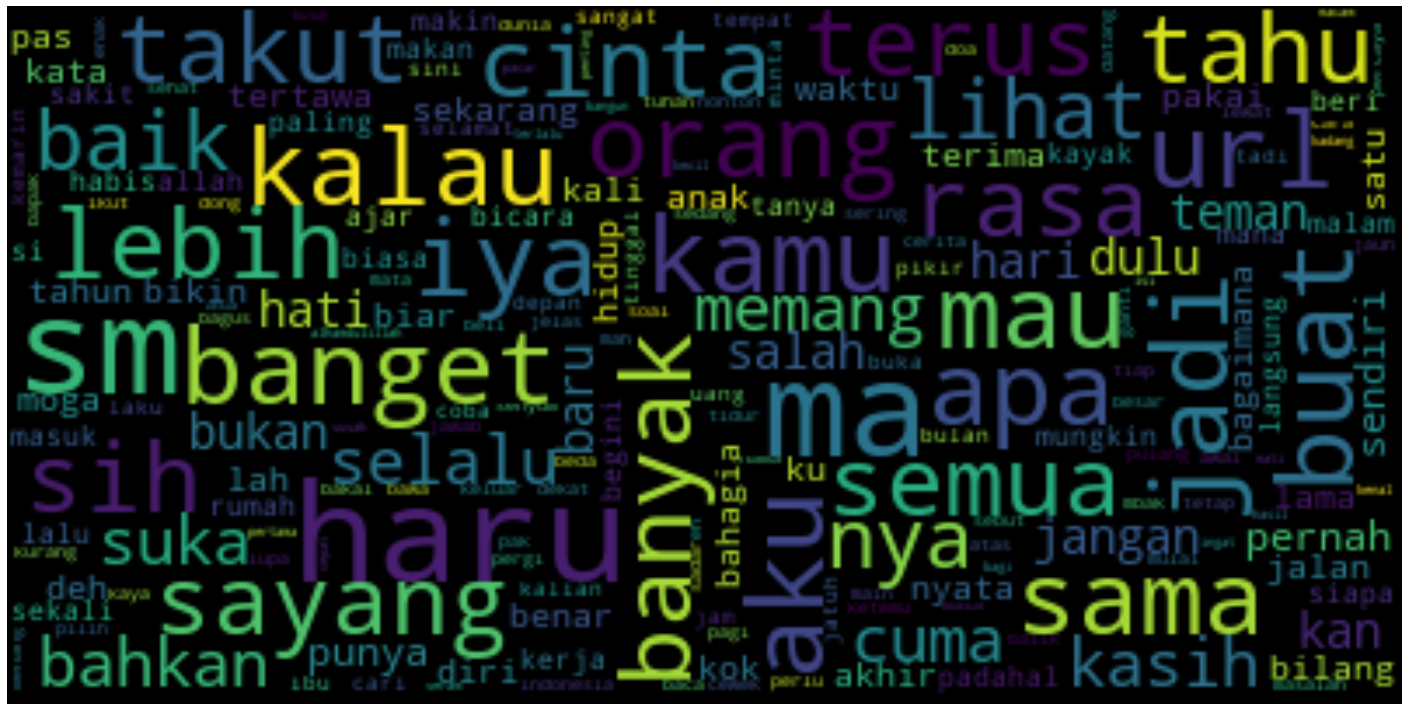

In [117]:
def plot_word_cloud(terms):
    text = terms.index
    text = ' '.join(list(text))
    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure(figsize=(25, 25))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

tfidf2 = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf2.columns = ['tfidf']    
plot_word_cloud(tfidf2.sort_values(by=['tfidf'], ascending=True))

#### 18. Text Representation
- CountVectorizer: Menghitung setiap jumlah kata/corpus yang muncul dalam kumpulan data tersebut
- Tfidf Transformer: Tranforming untuk perhitungan matriks dari CountVectorizer

In [78]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
Train_X_Tfidf = tfidf_transformer.fit_transform(X_train_counts)

#### 19. Membuat & Fitting Model Logistic Regression dengan solver lbfgs dan iteration 15000

In [79]:
LR_model = LogisticRegression(solver='lbfgs', max_iter=15000)
LR_model.fit(Train_X_Tfidf, y_train)

LogisticRegression(max_iter=15000)

#### 20. Melakukan count vectorizer dan tfidf transformer pada testing data

In [80]:
a = count_vect.transform(X_test)
Test_X_Tfidf = tfidf_transformer.fit_transform(a).toarray()
y_pred = LR_model.predict(Test_X_Tfidf)

#### 21. Evaluasi model Logistic Regression

In [81]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Accuracy %.2f " % (accuracy_score(y_pred, y_test) * 100))

[[ 8  1  1  0  0]
 [ 1 10  0  1  1]
 [ 1  1  8  0  3]
 [ 1  0  1  4  0]
 [ 1  0  0  0  1]]
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.83      0.77      0.80        13
           2       0.80      0.62      0.70        13
           3       0.80      0.67      0.73         6
           4       0.20      0.50      0.29         2

    accuracy                           0.70        44
   macro avg       0.66      0.67      0.65        44
weighted avg       0.75      0.70      0.72        44

Accuracy 70.45 


#### 22. Membuat & Fitting Model Multinomial Bayesian

In [82]:
mnb = MultinomialNB().fit(Train_X_Tfidf, y_train)
y_pred2 = mnb.predict(Test_X_Tfidf)

#### 23. Evaluasi Model Multinomial Bayesian

In [83]:
print(confusion_matrix(y_test,y_pred2))
print(classification_report(y_test,y_pred2))
print("Accuracy %.2f " % (accuracy_score(y_pred2, y_test) * 100))

[[ 9  0  1  0  0]
 [ 2  9  2  0  0]
 [ 2  0 11  0  0]
 [ 1  0  1  4  0]
 [ 2  0  0  0  0]]
              precision    recall  f1-score   support

           0       0.56      0.90      0.69        10
           1       1.00      0.69      0.82        13
           2       0.73      0.85      0.79        13
           3       1.00      0.67      0.80         6
           4       0.00      0.00      0.00         2

    accuracy                           0.75        44
   macro avg       0.66      0.62      0.62        44
weighted avg       0.78      0.75      0.74        44

Accuracy 75.00 


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### 24. Membuat model k-NN
Dikarenakan algoritma k-NN harus mencari K yang optimal, maka saya membuat iterasi sebanyak 500 untuk mencari optimal K kemudian digunakan untuk train/fit dan predicting 

In [84]:
Ks = 500
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors = n).fit(Train_X_Tfidf, y_train)
    yhat_knn=neigh.predict(Test_X_Tfidf)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat_knn)
    std_acc[n-1]=np.std(yhat_knn==y_test)/np.sqrt(yhat_knn.shape[0])

#### 25. Plotting Nilai K Optimal pada algoritma k-NN

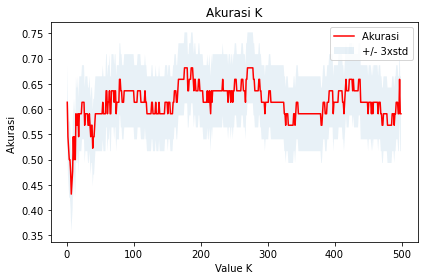

In [85]:
plt.plot(range(1, Ks), mean_acc, 'r')
plt.fill_between(range(1, Ks), mean_acc - 1 * std_acc, mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Akurasi ', '+/- 3xstd'))
plt.ylabel('Akurasi ')
plt.xlabel('Value K')
plt.title('Akurasi K')
plt.tight_layout()
plt.show()

#### 26. Print nilai K tertinggi

In [95]:
print("Akurasi tertinggi adalah %.2f"% (mean_acc.max() * 100), "% dengan nilai K=", mean_acc.argmax()+1) 

Akurasi tertinggi adalah 68.18 % dengan nilai K= 176


#### 27. Fitting model dengan k-NN dengan nilai K = 176

In [96]:
kNN_model = KNeighborsClassifier(n_neighbors = mean_acc.argmax()+1).fit(Train_X_Tfidf, y_train)
yhat_knn=neigh.predict(Test_X_Tfidf)

#### 28. Evaluasi model k-NN

In [97]:
print(confusion_matrix(y_test,yhat_knn))
print(classification_report(y_test,yhat_knn))
print("Accuracy %.2f " % (accuracy_score(yhat_knn, y_test) * 100))

[[8 1 1 0 0]
 [2 6 2 3 0]
 [2 0 6 1 4]
 [1 0 0 5 0]
 [0 0 0 1 1]]
              precision    recall  f1-score   support

           0       0.62      0.80      0.70        10
           1       0.86      0.46      0.60        13
           2       0.67      0.46      0.55        13
           3       0.50      0.83      0.62         6
           4       0.20      0.50      0.29         2

    accuracy                           0.59        44
   macro avg       0.57      0.61      0.55        44
weighted avg       0.67      0.59      0.59        44

Accuracy 59.09 


#### 29. Membuat test set dan testing dengan model Logistic Regression

In [101]:
test =['hari ini sangat indah',
       'kok kamu jelek bgt sih',
       'ada berita duka yang menyedihkan',
       'bagaimana kabar hari ini?',
       'semua baik-baik2 saja kan',
      'kenapa kamu sebodoh itu?',
      'kabar jogja hari ini',
      'kapan corona nya pergi',
      'aku takut dengan corona',
      'kamu sayang sama aku?',
      'aku sangat bahagia hari ini']

for i in test :
    a = count_vect.transform([i])
    X_coba = tfidf_transformer.fit_transform(a).toarray()
    y_pred = LR_model.predict(X_coba)
    if y_pred[0]== 0 :
        label = 'anger'
    elif y_pred[0]== 1 :
        label = 'happy'
    elif y_pred[0]== 2 :
        label = 'sadness'
    elif y_pred[0]== 3 :
        label = 'love'
    else :
        label = 'fear'
    print ({"teks": i , "label" : label})

{'teks': 'hari ini sangat indah', 'label': 'happy'}
{'teks': 'kok kamu jelek bgt sih', 'label': 'anger'}
{'teks': 'ada berita duka yang menyedihkan', 'label': 'sadness'}
{'teks': 'bagaimana kabar hari ini?', 'label': 'sadness'}
{'teks': 'semua baik-baik2 saja kan', 'label': 'anger'}
{'teks': 'kenapa kamu sebodoh itu?', 'label': 'anger'}
{'teks': 'kabar jogja hari ini', 'label': 'sadness'}
{'teks': 'kapan corona nya pergi', 'label': 'sadness'}
{'teks': 'aku takut dengan corona', 'label': 'fear'}
{'teks': 'kamu sayang sama aku?', 'label': 'love'}
{'teks': 'aku sangat bahagia hari ini', 'label': 'happy'}


#### 30. Testing dengan model Multinomial Bayesian

In [102]:
for i in test :
    a = count_vect.transform([i])
    X_coba = tfidf_transformer.fit_transform(a).toarray()
    y_pred = mnb.predict(X_coba)
    if y_pred[0]== 0 :
        label = 'anger'
    elif y_pred[0]== 1 :
        label = 'happy'
    elif y_pred[0]== 2 :
        label = 'sadness'
    elif y_pred[0]== 3 :
        label = 'love'
    else :
        label = 'fear'
    print ({"teks": i , "label" : label})

{'teks': 'hari ini sangat indah', 'label': 'happy'}
{'teks': 'kok kamu jelek bgt sih', 'label': 'anger'}
{'teks': 'ada berita duka yang menyedihkan', 'label': 'sadness'}
{'teks': 'bagaimana kabar hari ini?', 'label': 'sadness'}
{'teks': 'semua baik-baik2 saja kan', 'label': 'anger'}
{'teks': 'kenapa kamu sebodoh itu?', 'label': 'anger'}
{'teks': 'kabar jogja hari ini', 'label': 'sadness'}
{'teks': 'kapan corona nya pergi', 'label': 'sadness'}
{'teks': 'aku takut dengan corona', 'label': 'fear'}
{'teks': 'kamu sayang sama aku?', 'label': 'love'}
{'teks': 'aku sangat bahagia hari ini', 'label': 'happy'}


#### 31. Testing dengan model k-NN

In [103]:
for i in test :
    a = count_vect.transform([i])
    X_coba = tfidf_transformer.fit_transform(a).toarray()
    y_pred = kNN_model.predict(X_coba)
    if y_pred[0]== 0 :
        label = 'anger'
    elif y_pred[0]== 1 :
        label = 'happy'
    elif y_pred[0]== 2 :
        label = 'sadness'
    elif y_pred[0]== 3 :
        label = 'love'
    else :
        label = 'fear'
    print ({"teks": i , "label" : label})

{'teks': 'hari ini sangat indah', 'label': 'happy'}
{'teks': 'kok kamu jelek bgt sih', 'label': 'love'}
{'teks': 'ada berita duka yang menyedihkan', 'label': 'sadness'}
{'teks': 'bagaimana kabar hari ini?', 'label': 'sadness'}
{'teks': 'semua baik-baik2 saja kan', 'label': 'happy'}
{'teks': 'kenapa kamu sebodoh itu?', 'label': 'love'}
{'teks': 'kabar jogja hari ini', 'label': 'sadness'}
{'teks': 'kapan corona nya pergi', 'label': 'sadness'}
{'teks': 'aku takut dengan corona', 'label': 'fear'}
{'teks': 'kamu sayang sama aku?', 'label': 'love'}
{'teks': 'aku sangat bahagia hari ini', 'label': 'love'}
